In [445]:
# !pip3 install tensorflow pandas numpy matplotlib yahoo_fin sklearn fredapi openpyxl

In [446]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from yahoo_fin import stock_info as si
from collections import deque

import os
import numpy as np
import pandas as pd
import random
from fredapi import Fred

fred = Fred(api_key='39fa3bd07f8f55540a93e075a5f97cc1')

In [447]:
series_ids = [
    'CHNCPIALLMINMEI','USACPIALLMINMEI','BRACPIALLMINMEI','INDCPIALLMINMEI','BRAPROINDMISMEI'
    ,'USAPROINDMISMEI','PCUOMFGOMFG','RUSCPIALLMINMEI','PIEATI02RUM661N','RUSPROMANMISMEI'
    ,'UNRATENSA','GS10','M2NS','INTDSRUSM193N','TOTALNSA','MABMM301USM189S','ALTSALES','RSXFSN'
    ,'HTRUCKSSA','M2REAL','M1NS','BUSLOANS','MCOILWTICO','DAUPNSA','FRGSHPUSM649NCIS','PCU33443344'
    ,'AISRSA' ,'M1REAL','TRUCKD11','RAILFRTCARLOADS','MNFCTRIRNSA','DAUTOSAAR'
    ,'LTOTALNSA','MVMTD027MNFRBDAL','USEPUINDXM','CEU4348400001','CEU1021100001'
    ,'IPG3361T3S','TRESEGUSM052N','LAUTONSA','WPU114','RSGASSN','CMRMT','NATURALGAS'
    ,'EMVOVERALLEMV','PCU483111483111','WPU101706','GASREGCOVM','WPU11','PCU48214821'
    ,'WPU1413','MRTSIR441USN','U36SNO','PCU21112111','IPB53122N','IPB54100N','EXUSEU'
    ,'PCU4841214841212','GASDESM','EXCHUS','IPN213111N','PCU21212121','WPU012'
    # ,'M1109BUSM293NNBR','PCU484484','IC131','JTU2300JOL','WPU801104','WPU3011','PCU33613361'
]

In [448]:
# set seed, so we can get the same results after rerunning several times
np.random.seed(314)
tf.random.set_seed(314)
random.seed(314)

In [449]:
import os
import time
from tensorflow.keras.layers import LSTM

# Window size or the sequence length
N_STEPS = 1
# Lookup step, 1 is the next day
LOOKUP_STEP = 1

# whether to scale feature columns & output price as well
SCALE = True
scale_str = f"sc-{int(SCALE)}"
# whether to shuffle the dataset
SHUFFLE = True
shuffle_str = f"sh-{int(SHUFFLE)}"
# whether to split the training/testing set by date
SPLIT_BY_DATE = False
split_by_date_str = f"sbd-{int(SPLIT_BY_DATE)}"
# test ratio size, 0.2 is 20%
TEST_SIZE = 0.2
# features to use
# FEATURE_COLUMNS = ["close", "volume", "open", "high", "low","ema100"]
FEATURE_COLUMNS = ["close", "volume", "open", "high", "low","ma7","ma21"
                      # ,"ma100","ma50"
                      ,"26ema","12ema","MACD","ema","momentum" ] + series_ids

# date now
date_now = time.strftime("%Y-%m-%d")

### model parameters

N_LAYERS = 2
# LSTM cell
CELL = LSTM
# 256 LSTM neurons
UNITS = 256
# 40% dropout
DROPOUT = 0.4
# whether to use bidirectional RNNs
BIDIRECTIONAL = False

### training parameters

# mean absolute error loss
# LOSS = "mae"
# huber loss
LOSS = "huber_loss"
OPTIMIZER = "adam"
BATCH_SIZE = 64
EPOCHS = 700

# Amazon stock market
ticker = "^GSPC"
ticker_data_filename = os.path.join("data", f"{ticker}_{date_now}")
# model name to save, making it as unique as possible based on parameters
model_name = f"{date_now}_{ticker}-{shuffle_str}-{scale_str}-{split_by_date_str}-\
{LOSS}-{OPTIMIZER}-{CELL.__name__}-seq-{N_STEPS}-step-{LOOKUP_STEP}-layers-{N_LAYERS}-units-{UNITS}"
if BIDIRECTIONAL:
    model_name += "-b"

In [450]:
def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['close'].rolling(window=7).mean()
    dataset['ma21'] = dataset['close'].rolling(window=21).mean()
    # dataset['ma100'] = dataset['close'].rolling(window=100).mean()
    # dataset['ma50'] = dataset['close'].rolling(window=50).mean()

    # Create MACD
	# candles['ema20'] = pd.Series.ewm(candles['<CLOSE>'], span=20).mean()
    dataset['26ema'] = pd.Series.ewm(dataset['close'], span=26).mean()
    dataset['12ema'] = pd.Series.ewm(dataset['close'], span=12).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

    # Create Bollinger Bands
    # dataset['20sd'] = pd.stats.moments.rolling_std(dataset['GS'],20)
    # dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    # dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)

    # Create Exponential moving average
    dataset['ema'] = dataset['close'].ewm(com=0.5).mean()

    # Create Momentum
    dataset['momentum'] = dataset['close']-1

    dataset.replace('', np.nan, inplace=True)
    dataset = dataset.dropna()

    return dataset

def shuffle_in_unison(a, b):
    # shuffle two arrays in the same way
    state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(state)
    np.random.shuffle(b)


def load_data(ticker, n_steps=10, scale=True, shuffle=True, lookup_step=1, split_by_date=True,
                test_size=0.2, feature_columns=['close', 'volume', 'open', 'high', 'low']):
    """
    Loads data from Yahoo Finance source, as well as scaling, shuffling, normalizing and splitting.
    Params:
        ticker (str/pd.DataFrame): the ticker you want to load, examples include AAPL, TESL, etc.
        n_steps (int): the historical sequence length (i.e window size) used to predict, default is 50
        scale (bool): whether to scale prices from 0 to 1, default is True
        shuffle (bool): whether to shuffle the dataset (both training & testing), default is True
        lookup_step (int): the future lookup step to predict, default is 1 (e.g next day)
        split_by_date (bool): whether we split the dataset into training/testing by date, setting it 
            to False will split datasets in a random way
        test_size (float): ratio for test data, default is 0.2 (20% testing data)
        feature_columns (list): the list of features to use to feed into the model, default is everything grabbed from yahoo_fin
    """
    # see if ticker is already a loaded stock from yahoo finance
    if isinstance(ticker, str):
        # load it from yahoo_fin library
        # df = si.get_data(ticker)
        df = si.get_data(ticker,start_date = '2000-01-01', end_date = None, index_as_date = True, interval= "1mo")
        # get_data(ticker, start_date = None, end_date = None, index_as_date = True, interval = “1d”)
    elif isinstance(ticker, pd.DataFrame):
        # already loaded, use it directly
        df = ticker
    else:
        raise TypeError("ticker can be either a str or a `pd.DataFrame` instances")


    df = get_technical_indicators(df)
    df_fred = get_fred()
    df = pd.concat([df_fred , df], axis=1)

    df.replace('', np.nan, inplace=True)
    df = df.dropna()

    # print(df.tail)
    # this will contain all the elements we want to return from this function
    result = {}
    # we will also return the original dataframe itself
    result['df'] = df.copy()

    # make sure that the passed feature_columns exist in the dataframe
    for col in feature_columns:
        assert col in df.columns, f"'{col}' does not exist in the dataframe."

    # add date as a column
    if "date" not in df.columns:
        df["date"] = df.index

    if scale:
        column_scaler = {}
        # scale the data (prices) from 0 to 1
        for column in feature_columns:
            scaler = preprocessing.MinMaxScaler()
            df[column] = scaler.fit_transform(np.expand_dims(df[column].values, axis=1))
            column_scaler[column] = scaler

        # add the MinMaxScaler instances to the result returned
        result["column_scaler"] = column_scaler

    # add the target column (label) by shifting by `lookup_step`
    df['future'] = df['close'].shift(-lookup_step)

    # last `lookup_step` columns contains NaN in future column
    # get them before droping NaNs
    last_sequence = np.array(df[feature_columns].tail(lookup_step))
    
    # drop NaNs
    df.dropna(inplace=True)

    sequence_data = []
    sequences = deque(maxlen=n_steps)

    for entry, target in zip(df[feature_columns + ["date"]].values, df['future'].values):
        sequences.append(entry)
        if len(sequences) == n_steps:
            sequence_data.append([np.array(sequences), target])

    # get the last sequence by appending the last `n_step` sequence with `lookup_step` sequence
    # for instance, if n_steps=50 and lookup_step=10, last_sequence should be of 60 (that is 50+10) length
    # this last_sequence will be used to predict future stock prices that are not available in the dataset
    last_sequence = list([s[:len(feature_columns)] for s in sequences]) + list(last_sequence)
    last_sequence = np.array(last_sequence).astype(np.float32)
    # add to result
    result['last_sequence'] = last_sequence
    
    # construct the X's and y's
    X, y = [], []
    for seq, target in sequence_data:
        X.append(seq)
        y.append(target)

    # convert to numpy arrays
    X = np.array(X)
    y = np.array(y)

    if split_by_date:
        # split the dataset into training & testing sets by date (not randomly splitting)
        train_samples = int((1 - test_size) * len(X))
        result["X_train"] = X[:train_samples]
        result["y_train"] = y[:train_samples]
        result["X_test"]  = X[train_samples:]
        result["y_test"]  = y[train_samples:]
        if shuffle:
            # shuffle the datasets for training (if shuffle parameter is set)
            shuffle_in_unison(result["X_train"], result["y_train"])
            shuffle_in_unison(result["X_test"], result["y_test"])
    else:    
        # split the dataset randomly
        result["X_train"], result["X_test"], result["y_train"], result["y_test"] = train_test_split(X, y, 
                                                                                test_size=test_size, shuffle=shuffle)

    # get the list of test set dates
    dates = result["X_test"][:, -1, -1]
    # retrieve test features from the original dataframe
    result["test_df"] = result["df"].loc[dates]
    # remove duplicated dates in the testing dataframe
    result["test_df"] = result["test_df"][~result["test_df"].index.duplicated(keep='first')]
    # remove dates from the training/testing sets & convert to float32
    result["X_train"] = result["X_train"][:, :, :len(feature_columns)].astype(np.float32)
    result["X_test"] = result["X_test"][:, :, :len(feature_columns)].astype(np.float32)

    return result

def get_fred():
    # series_ids = ['PCPI06037', 'PCPI06075', 'PCPI24510']
    # ticker_fred = 'SP500'
    # dataset_fred = fred.get_series(ticker_fred, observation_start="1/1/2000")
    # print(dataset_fred)
    # dataset_fred = pd.DataFrame({'date':dataset_fred.index.tolist(),ticker_fred:dataset_fred.tolist()})
    # dataset_fred.set_index('date', inplace=True)
    #
    # dataset = pd.concat([dataset, dataset_fred],axis=1)
    data_ = {}
    for series_id in series_ids:
        data_[series_id] = fred.get_series(series_id, observation_start='1/1/2000')
    dataset_ = pd.concat(data_, axis=1)
    dataset_.replace('', np.nan, inplace=True)
    dataset_=dataset_.fillna(dataset_[-10:].mean())
    # dataset = pd.concat([dataset , df], axis=1)
    # print(df)

    return dataset_

In [451]:
# data_s = []
# data_s = pd.DataFrame
# data_s = get_fred('SP500')
# ticker_fred = 'SP500'
# dataset_fred_ = fred.get_series(ticker_fred)
# print(dataset_fred_)
# ddf = get_fred()
# ddf

In [452]:
# ddf.to_excel("fred.xlsx")

In [453]:
# df_yaho = si.get_data(ticker,start_date = '2000-01-01', end_date = None, index_as_date = True, interval= "1mo")

In [454]:
# df_yaho

In [455]:
# df_sum = pd.concat([df_yaho,ddf],axis=1)

In [456]:
# df_sum
# df_sum.to_excel("view.xlsx")

In [457]:
# df_sum.replace('', np.nan, inplace=True)

In [458]:
# df_sum.fillna(method='ffill')
# df_sum_out=df_sum.fillna(df_sum[-10:].mean())
# df_sum = df_sum.dropna()
# data_s.to_excel("test.xlsx")
# data_s.to_excel("test.xlsx")

In [459]:
# df_sum_out

In [460]:
# df_sum_out.to_excel("view2.xlsx")

In [461]:
def create_model(sequence_length, n_features, units=256, cell=LSTM, n_layers=2, dropout=0.3,
                loss="mean_absolute_error", optimizer="rmsprop", bidirectional=False):
    model = Sequential()
    for i in range(n_layers):
        if i == 0:
            # first layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True), batch_input_shape=(None, sequence_length, n_features)))
            else:
                model.add(cell(units, return_sequences=True, batch_input_shape=(None, sequence_length, n_features)))
        elif i == n_layers - 1:
            # last layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=False)))
            else:
                model.add(cell(units, return_sequences=False))
        else:
            # hidden layers
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True)))
            else:
                model.add(cell(units, return_sequences=True))
        # add dropout after each layer
        model.add(Dropout(dropout))
    model.add(Dense(1, activation="linear"))
    model.compile(loss=loss, metrics=["mean_absolute_error"], optimizer=optimizer)
    return model

In [462]:
# create these folders if they does not exist
if not os.path.isdir("results"):
    os.mkdir("results")

if not os.path.isdir("logs"):
    os.mkdir("logs")

if not os.path.isdir("data"):
    os.mkdir("data")

# load the data
data = load_data(ticker, N_STEPS, scale=SCALE, split_by_date=SPLIT_BY_DATE, 
                shuffle=SHUFFLE, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE, 
                feature_columns=FEATURE_COLUMNS)

# save the dataframe
# data["df"].to_csv(ticker_data_filename + ".csv")
data["df"].to_excel("view.xlsx")
# data.to_csv(ticker_data_filename + "_2.csv")

# construct the model
model = create_model(N_STEPS, len(FEATURE_COLUMNS), loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
                    dropout=DROPOUT, optimizer=OPTIMIZER, bidirectional=BIDIRECTIONAL)

In [463]:
# data["df"] = data["df"].dropna()

In [464]:
# data["df"]

In [465]:
data["df"].to_excel("view_start.xlsx")

In [466]:
""""
if os.path.exists(os.path.join("results", model_name + ".h5")):
	print("Модель уже просчитана, загружаем модель")
	# model = keras.models.load_model(path_best_model)

else:"""
# some tensorflow callbacks
checkpointer = ModelCheckpoint(os.path.join("results", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))
# train the model and save the weights whenever we see
# a new optimal model using ModelCheckpoint
history = model.fit(data["X_train"], data["y_train"],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(data["X_test"], data["y_test"]),
                    callbacks=[checkpointer, tensorboard],
                    verbose=1)

Epoch 1/700
1/3 [=========>....................] - ETA: 9s - loss: 0.0491 - mean_absolute_error: 0.2425
Epoch 00001: val_loss improved from inf to 0.01700, saving model to results\2021-11-27_^GSPC-sh-1-sc-1-sbd-0-huber_loss-adam-LSTM-seq-1-step-1-layers-2-units-256.h5
3/3 [==============================] - 6s 600ms/step - loss: 0.0417 - mean_absolute_error: 0.2054 - val_loss: 0.0170 - val_mean_absolute_error: 0.1274
Epoch 2/700
1/3 [=========>....................] - ETA: 0s - loss: 0.0143 - mean_absolute_error: 0.1172
Epoch 00002: val_loss improved from 0.01700 to 0.01532, saving model to results\2021-11-27_^GSPC-sh-1-sc-1-sbd-0-huber_loss-adam-LSTM-seq-1-step-1-layers-2-units-256.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0147 - mean_absolute_error: 0.1352 - val_loss: 0.0153 - val_mean_absolute_error: 0.1579
Epoch 3/700
1/3 [=========>....................] - ETA: 0s - loss: 0.0183 - mean_absolute_error: 0.1717
Epoch 00003: val_loss improved from 0.01532 to 0.0066

In [467]:
import matplotlib.pyplot as plt

def plot_graph(test_df):
    """
    This function plots true close price along with predicted close price
    with blue and red colors respectively
    """
    plt.plot(test_df[f'true_close_{LOOKUP_STEP}'], c='b')
    plt.plot(test_df[f'close_{LOOKUP_STEP}'], c='r')
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.legend(["Actual Price", "Predicted Price"])
    plt.show()

In [468]:
def get_final_df(model, data):
    """
    This function takes the `model` and `data` dict to 
    construct a final dataframe that includes the features along 
    with true and predicted prices of the testing dataset
    """
    # if predicted future price is higher than the current, 
    # then calculate the true future price minus the current price, to get the buy profit
    buy_profit  = lambda current, pred_future, true_future: true_future - current if pred_future > current else 0
    # if the predicted future price is lower than the current price,
    # then subtract the true future price from the current price
    sell_profit = lambda current, pred_future, true_future: current - true_future if pred_future < current else 0
    X_test = data["X_test"]
    y_test = data["y_test"]
    # perform prediction and get prices
    y_pred = model.predict(X_test)
    if SCALE:
        y_test = np.squeeze(data["column_scaler"]["close"].inverse_transform(np.expand_dims(y_test, axis=0)))
        y_pred = np.squeeze(data["column_scaler"]["close"].inverse_transform(y_pred))
    test_df = data["test_df"]
    # add predicted future prices to the dataframe
    test_df[f"close_{LOOKUP_STEP}"] = y_pred
    # add true future prices to the dataframe
    test_df[f"true_close_{LOOKUP_STEP}"] = y_test
    # sort the dataframe by date
    test_df.sort_index(inplace=True)
    final_df = test_df
    # add the buy profit column
    final_df["buy_profit"] = list(map(buy_profit, 
                                    final_df["close"],
                                    final_df[f"close_{LOOKUP_STEP}"],
                                    final_df[f"true_close_{LOOKUP_STEP}"])
                                    # since we don't have profit for last sequence, add 0's
                                    )
    # add the sell profit column
    final_df["sell_profit"] = list(map(sell_profit, 
                                    final_df["close"],
                                    final_df[f"close_{LOOKUP_STEP}"],
                                    final_df[f"true_close_{LOOKUP_STEP}"])
                                    # since we don't have profit for last sequence, add 0's
                                    )
    return final_df

In [469]:
def predict(model, data):
    # retrieve the last sequence from data
    last_sequence = data["last_sequence"][-N_STEPS:]
    # expand dimension
    last_sequence = np.expand_dims(last_sequence, axis=0)
    # get the prediction (scaled from 0 to 1)
    prediction = model.predict(last_sequence)
    # get the price (by inverting the scaling)
    if SCALE:
        predicted_price = data["column_scaler"]["close"].inverse_transform(prediction)[0][0]
    else:
        predicted_price = prediction[0][0]
    return predicted_price

In [470]:
# load optimal model weights from results folder
model_path = os.path.join("results", model_name) + ".h5"
model.load_weights(model_path)

In [471]:
# evaluate the model
loss, mae = model.evaluate(data["X_test"], data["y_test"], verbose=0)
# calculate the mean absolute error (inverse scaling)
if SCALE:
    mean_absolute_error = data["column_scaler"]["close"].inverse_transform([[mae]])[0][0]
else:
    mean_absolute_error = mae

In [472]:
# get the final dataframe for the testing set
final_df = get_final_df(model, data)

In [473]:
# predict the future price
future_price = predict(model, data)

In [474]:
future_price

4507.396

In [475]:
# we calculate the accuracy by counting the number of positive profits
accuracy_score = (len(final_df[final_df['sell_profit'] > 0]) + len(final_df[final_df['buy_profit'] > 0])) / len(final_df)
# calculating total buy & sell profit
total_buy_profit  = final_df["buy_profit"].sum()
total_sell_profit = final_df["sell_profit"].sum()
# total profit by adding sell & buy together
total_profit = total_buy_profit + total_sell_profit
# dividing total profit by number of testing samples (number of trades)
profit_per_trade = total_profit / len(final_df)

In [476]:
# printing metrics
print(f"Future price after {LOOKUP_STEP} days is {future_price:.2f}$")
print(f"{LOSS} loss:", loss)
print("Mean Absolute Error:", mean_absolute_error)
print("Accuracy score:", accuracy_score)
print("Total buy profit:", total_buy_profit)
print("Total sell profit:", total_sell_profit)
print("Total profit:", total_profit)
print("Profit per trade:", profit_per_trade)

Future price after 1 days is 4507.40$
huber_loss loss: 0.0002043728600256145
Mean Absolute Error: 794.2592488414449
Accuracy score: 0.5918367346938775
Total buy profit: 411.67028808593795
Total sell profit: 530.7999267578124
Total profit: 942.4702148437503
Profit per trade: 19.234086017219393


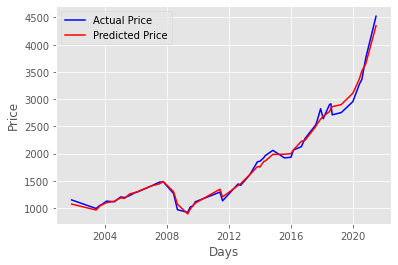

In [477]:
# plot true/pred prices graph
plot_graph(final_df)

In [478]:
final_df.head(20)

,CHNCPIALLMINMEI,USACPIALLMINMEI,BRACPIALLMINMEI,INDCPIALLMINMEI,BRAPROINDMISMEI,USAPROINDMISMEI,PCUOMFGOMFG,RUSCPIALLMINMEI,PIEATI02RUM661N,RUSPROMANMISMEI,...,ma21,26ema,12ema,MACD,ema,momentum,close_1,true_close_1,buy_profit,sell_profit
2001-11-01,70.777981,74.846952,41.783996,39.136622,83.163455,87.329391,132.7,25.806427,21.147724,53.721605,...,1302.703793,1247.306845,1189.125687,-58.181158,1115.276460,1138.449951,1071.648438,1148.079956,0.000000,-8.630005
2003-06-01,70.038462,77.504989,50.467978,41.209537,86.099642,89.937602,136.3,32.562486,26.058890,57.717691,...,981.448097,1002.221903,935.591515,-66.630388,963.154458,973.500000,962.451111,990.309998,0.000000,-15.809998
2003-09-01,71.018201,78.137855,51.136637,41.375370,89.402697,90.827986,137.1,32.770267,27.492042,58.958453,...,964.637623,1001.372698,960.348476,-41.024222,997.010888,994.969971,1037.929077,1050.709961,54.739990,0.000000
2003-10-01,71.657364,78.053473,51.284893,41.707036,89.843105,90.928790,138.2,33.097970,27.719249,59.986179,...,960.852385,1005.136488,974.256639,-30.879848,1032.810270,1049.709961,1050.734741,1058.199951,7.489990,0.000000
2004-02-01,73.461853,78.559766,52.437761,41.789953,92.485549,92.288700,139.3,34.714798,29.991318,65.642278,...,963.138570,1034.665134,1043.940929,9.275795,1135.899103,1143.939941,1097.700073,1126.209961,0.000000,18.729980
2004-08-01,73.825029,79.952071,54.385503,43.282451,96.449216,93.024557,143.7,36.342252,33.556720,65.130335,...,1022.478091,1065.198685,1089.055767,23.857081,1106.925911,1103.239990,1123.018188,1114.579956,10.339966,0.000000
2004-09-01,74.637104,80.120835,54.565081,43.365368,97.109827,93.111485,144.2,36.498523,34.605367,64.243999,...,1033.657136,1068.902637,1092.982853,24.080215,1112.028608,1113.579956,1138.211426,1130.199951,15.619995,0.000000
2005-01-01,74.934531,80.458364,55.980587,43.614117,97.660336,95.269399,146.2,38.738902,36.125906,65.838104,...,1092.479039,1097.564760,1134.423003,36.858243,1185.413457,1180.270020,1186.475586,1203.599976,22.329956,0.000000
2005-04-01,75.370012,82.103815,57.147144,43.862867,97.219928,96.010213,149.6,40.185975,38.432930,68.838945,...,1121.652367,1114.507639,1151.503453,36.995814,1166.646399,1155.849976,1175.471558,1191.500000,34.650024,0.000000
2005-08-01,74.766753,82.863255,57.657107,44.774949,98.100743,96.527415,151.8,40.896901,40.477793,69.427724,...,1156.149990,1140.096906,1180.969860,40.872954,1219.884997,1219.329956,1259.066650,1228.810059,8.480103,0.000000


In [479]:
final_df.tail(20)

,CHNCPIALLMINMEI,USACPIALLMINMEI,BRACPIALLMINMEI,INDCPIALLMINMEI,BRAPROINDMISMEI,USAPROINDMISMEI,PCUOMFGOMFG,RUSCPIALLMINMEI,PIEATI02RUM661N,RUSPROMANMISMEI,...,ma21,26ema,12ema,MACD,ema,momentum,close_1,true_close_1,buy_profit,sell_profit
2014-05-01,98.300000,100.372547,91.471949,93.337584,108.780622,101.331603,197.2,85.829110,87.550323,92.984503,...,1659.268090,1642.946809,1783.187832,140.241024,1907.823310,1922.569946,1860.521118,1960.229980,0.000000,-36.660034
2014-11-01,98.600000,99.634625,93.464701,96.780363,108.560418,102.753363,192.7,89.406067,88.917585,97.383769,...,1813.752854,1773.897175,1922.308224,148.411049,2046.275613,2066.560059,1984.935059,2058.899902,0.000000,8.660156
2015-08-01,100.400000,100.548062,100.847560,100.988205,99.421965,100.022244,187.0,100.711169,102.779014,101.383103,...,1984.797137,1917.373328,2028.240003,110.866675,2012.847784,1971.180054,1987.589111,1920.030029,-52.150024,0.000000
2016-01-01,101.100000,99.957387,105.570863,102.900861,94.687586,98.603061,179.7,104.586033,99.022299,97.883686,...,2023.715716,1947.771757,2018.722471,70.950714,1977.234906,1939.239990,1998.918823,1932.229980,-8.010010,0.000000
2016-03-01,102.200000,100.470430,106.978945,102.518330,94.137077,97.330079,179.3,105.729052,100.832293,100.183303,...,2028.866670,1954.999737,2013.773481,58.773744,2022.237201,2058.739990,2067.511719,2065.300049,5.560059,0.000000
2016-09-01,102.400000,101.861048,109.986054,105.961109,93.036058,97.737061,183.0,107.785079,106.229722,101.083153,...,2063.299531,2021.240190,2093.536543,72.296353,2166.476743,2167.270020,2223.591309,2126.149902,-42.120117,0.000000
2016-12-01,102.600000,101.862736,110.802041,105.196047,94.137077,98.024307,183.9,109.159747,108.117845,102.782870,...,2082.176206,2056.199425,2133.186008,76.986582,2218.910308,2237.830078,2246.772461,2278.870117,40.040039,0.000000
2017-08-01,103.500000,103.587084,112.597119,109.021358,95.788604,98.826871,188.4,111.145962,110.921862,107.682053,...,2213.355236,2216.892534,2342.164883,125.272349,2465.084166,2470.649902,2488.587158,2519.360107,47.710205,0.000000
2017-09-01,104.100000,104.135568,112.777160,109.021358,96.229012,98.869493,189.6,110.979243,113.596374,109.581736,...,2235.994292,2239.297541,2369.425687,130.128146,2501.268127,2518.360107,2532.872803,2575.260010,55.899902,0.000000
2017-12-01,104.500000,104.011105,114.067844,109.403889,100.522984,100.476307,191.3,111.913917,117.342856,105.982336,...,2329.529541,2320.807592,2475.105430,154.297838,2654.157428,2672.610107,2631.301514,2823.810059,0.000000,-150.199951


In [480]:
# save the final dataframe to csv-results folder
csv_results_folder = "csv-results"
if not os.path.isdir(csv_results_folder):
    os.mkdir(csv_results_folder)
csv_filename = os.path.join(csv_results_folder, model_name + ".csv")
final_df.to_csv(csv_filename)

In [481]:
candles = final_df
import datetime
candles.rename(columns={'close_15':'predict','true_close_15':'test'}, inplace=True)

In [482]:
# Рисует основной график
def draw_candles(candles):
    # Добавим на график несколько ЕМА-средних
    # candles['ema100'] = pd.Series.ewm(candles['close'], span=100).mean()
    # candles['ema50'] = pd.Series.ewm(candles['close'], span=50).mean()
    # candles['ema20'] = pd.Series.ewm(candles['close'], span=20).mean()
    # candles['26ema'] = pd.Series.ewm(candles['close'], span=26).mean()
    # candles['12ema'] = pd.Series.ewm(candles['close'], span=12).mean()
    # candles['MACD'] = (candles['12ema']-candles['26ema'])
    plt.style.use('ggplot')  # 'seaborn-paper'
    # Отображаем график по цене закрытия свечей и ЕМА-шки
    fig = candles.plot(y=['test', 'predict','26ema','MACD','12ema'], figsize=(25, 16))
    # Добавляем заголовок
    fig.set_title('График ' + ticker)
    # Рисуем шкалу с датами
    PlotDatesX(fig, candles)

# Определяет начальную и конечную позицию Х (по индексу свечей) для заданной даты. Пригодится при отрисовке ценовых уровней
def DateX(date, candles):
    # Цикл по датам в свечах, результат - список X-координат, соответствующих заданной дате
    xpositions = [index for index, row in candles.iterrows() if row['Date'].date() == date]
    # Возвращает список - пару начальная координата Х и конечная координата Х для заданной даты на графике
    if xpositions == []:
        return [len(candles) - 1, len(candles)]  # На случай если за текущую дату нет еще свечей
    return [xpositions[0], xpositions[-1]]


# Рисует метки дат на оси Х
def PlotDatesX(fig, candles):
    # Составляем список дат (только уникальные даты) из столбца DT. Они будут метками на оси Х. Сортировка по датам
    # обязательна, т.к. при создании множества(set) даже из отсортированного списка, множество может не сохранить порядок списка
    dates = sorted(set(map(lambda dt: datetime.date(dt), candles['Date'])))
    # Создаем список координат Х для каждой метки (даты). Нам нужна только первая позиция - [0].
    xlabel = [DateX(d, candles)[0] for d in dates]
    # Рисуем ось Х, разделенную по датам
    fig.set_xticklabels(dates)
    fig.set_xticks(xlabel)
    return dates, xlabel

In [483]:
candles.rename(columns={'close_15':'predict','true_close_15':'test'}, inplace=True)
candles['Date'] = candles.index
candles['ema100'] = pd.Series.ewm(candles['close'], span=100).mean()
candles['ema50'] = pd.Series.ewm(candles['close'], span=50).mean()
candles['ema20'] = pd.Series.ewm(candles['close'], span=20).mean()
candles['26ema'] = pd.Series.ewm(candles['close'], span=26).mean()
candles['12ema'] = pd.Series.ewm(candles['close'], span=12).mean()
candles['MACD'] = (candles['12ema']-candles['26ema'])
# candles['Date']= datetime.datetime.strptime(str(candles['Date']), '%Y-%m-%d').date()#pd.to_datetime(candles['Date'],format='%Y%m%d')
candles.tail(20)

,CHNCPIALLMINMEI,USACPIALLMINMEI,BRACPIALLMINMEI,INDCPIALLMINMEI,BRAPROINDMISMEI,USAPROINDMISMEI,PCUOMFGOMFG,RUSCPIALLMINMEI,PIEATI02RUM661N,RUSPROMANMISMEI,...,ema,momentum,close_1,true_close_1,buy_profit,sell_profit,Date,ema100,ema50,ema20
2014-05-01,98.300000,100.372547,91.471949,93.337584,108.780622,101.331603,197.2,85.829110,87.550323,92.984503,...,1907.823310,1922.569946,1860.521118,1960.229980,0.000000,-36.660034,2014-05-01,1332.297764,1367.972110,1475.366874
2014-11-01,98.600000,99.634625,93.464701,96.780363,108.560418,102.753363,192.7,89.406067,88.917585,97.383769,...,2046.275613,2066.560059,1984.935059,2058.899902,0.000000,8.660156,2014-11-01,1363.807609,1406.576620,1534.419631
2015-08-01,100.400000,100.548062,100.847560,100.988205,99.421965,100.022244,187.0,100.711169,102.779014,101.383103,...,2012.847784,1971.180054,1987.589111,1920.030029,-52.150024,0.000000,2015-08-01,1389.292058,1437.297139,1577.877827
2016-01-01,101.100000,99.957387,105.570863,102.900861,94.687586,98.603061,179.7,104.586033,99.022299,97.883686,...,1977.234906,1939.239990,1998.918823,1932.229980,-8.010010,0.000000,2016-01-01,1411.872278,1464.207950,1613.706344
2016-03-01,102.200000,100.470430,106.978945,102.518330,94.137077,97.330079,179.3,105.729052,100.832293,100.183303,...,2022.237201,2058.739990,2067.511719,2065.300049,5.560059,0.000000,2016-03-01,1437.873914,1495.623937,1657.648062
2016-09-01,102.400000,101.861048,109.986054,105.961109,93.036058,97.737061,183.0,107.785079,106.229722,101.083153,...,2166.476743,2167.270020,2223.591309,2126.149902,-42.120117,0.000000,2016-09-01,1466.603620,1530.633971,1707.788416
2016-12-01,102.600000,101.862736,110.802041,105.196047,94.137077,98.024307,183.9,109.159747,108.117845,102.782870,...,2218.910308,2237.830078,2246.772461,2278.870117,40.040039,0.000000,2016-12-01,1496.396766,1567.027302,1759.780158
2017-08-01,103.500000,103.587084,112.597119,109.021358,95.788604,98.826871,188.4,111.145962,110.921862,107.682053,...,2465.084166,2470.649902,2488.587158,2519.360107,47.710205,0.000000,2017-08-01,1533.329301,1612.955660,1829.290520
2017-09-01,104.100000,104.135568,112.777160,109.021358,96.229012,98.869493,189.6,110.979243,113.596374,109.581736,...,2501.268127,2518.360107,2532.872803,2575.260010,55.899902,0.000000,2017-09-01,1570.007296,1658.448808,1896.510433
2017-12-01,104.500000,104.011105,114.067844,109.403889,100.522984,100.476307,191.3,111.913917,117.342856,105.982336,...,2654.157428,2672.610107,2631.301514,2823.810059,0.000000,-150.199951,2017-12-01,1610.356783,1708.847418,1972.043899


In [484]:

draw_candles(candles.tail(1000))

KeyError: "['test', 'predict'] not in index"